In [19]:
import matplotlib.pyplot as plt
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matyplotlib -rf
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

Sudo媛� �씠 而댄벂�꽣�뿉�꽌 �궗�슜�븯吏� �븡�룄濡� �꽕�젙�릺�뼱 �엳�뒿�땲�떎. �궗�슜�븯�룄濡� �꽕�젙�븯�젮硫� �쑝濡� �씠�룞�븯�꽭�슂. ]8;;ms-settings:developers\Developer Settings page]8;;\ �꽕�젙 �빋�쓽
Sudo媛� �씠 而댄벂�꽣�뿉�꽌 �궗�슜�븯吏� �븡�룄濡� �꽕�젙�릺�뼱 �엳�뒿�땲�떎. �궗�슜�븯�룄濡� �꽕�젙�븯�젮硫� �쑝濡� �씠�룞�븯�꽭�슂. ]8;;ms-settings:developers\Developer Settings page]8;;\ �꽕�젙 �빋�쓽
'rm'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import random

plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)
BASE = Path.cwd().parents[1] / "python-server" / "app" / "data_pipeline"

FEATURES_PATH = BASE / "features_all.csv"
SALES_PATH = BASE / "weekly_sales.csv"
SKU_PATH = BASE / "sku_catalog_ml_with_share.csv"

print("FEATURES:", FEATURES_PATH)
print("SALES   :", SALES_PATH)
print("SKU     :", SKU_PATH)

df_feat = pd.read_csv(FEATURES_PATH, parse_dates=["target_date"])
df_sales = pd.read_csv(SALES_PATH, parse_dates=["target_date"])
df_sku = pd.read_csv(SKU_PATH)

print("전체 Features row:", len(df_feat))

# 2025년 이전만 사용 (2021~2024)
df_feat_train = df_feat[df_feat["target_date"] < "2025-01-01"].copy()

print("Train rows:", len(df_feat_train))
df_feat_train.head()

y_col = "actual_order_qty"
print("Target column:", y_col)

FEATURES: C:\Users\chosw\ORDER101_210_refact_jupyter\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline\features_all.csv
SALES   : C:\Users\chosw\ORDER101_210_refact_jupyter\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline\weekly_sales.csv
SKU     : C:\Users\chosw\ORDER101_210_refact_jupyter\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline\sku_catalog_ml_with_share.csv
전체 Features row: 51294
Train rows: 40582
Target column: actual_order_qty


## 타겟 분포 Long-tail 분석
로그 스케일 포함
  
원본 분포  
0~20 사이에 몰리고 뒤로 롱테일  
매우 정상적인 전자제품 주간 판매 패턴  
long-tail → lightgbm 기본 목적함수로도 잘 맞지만  
log1p 변환 시 더 안정적  
   
로그 분포  
중앙값이 2~3 근처  
완전한 정규분포는 아니지만 “예측 가능한 형태”  
→ 로그 변환을 적용한 모델 버전 추가하면 성능 상승 거의 확정.  

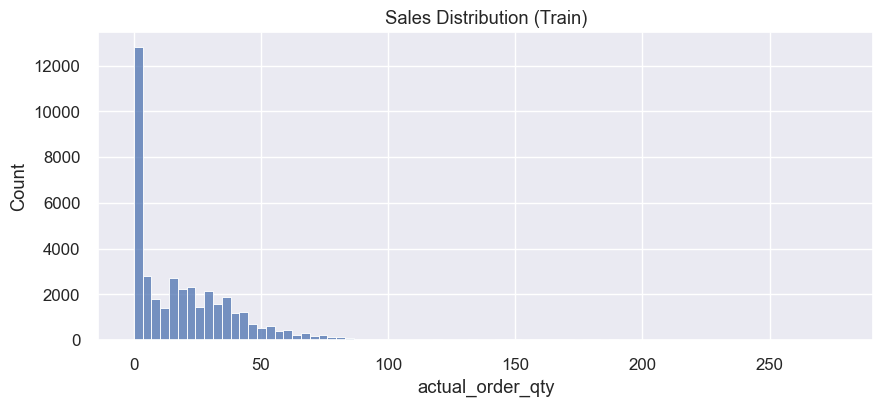

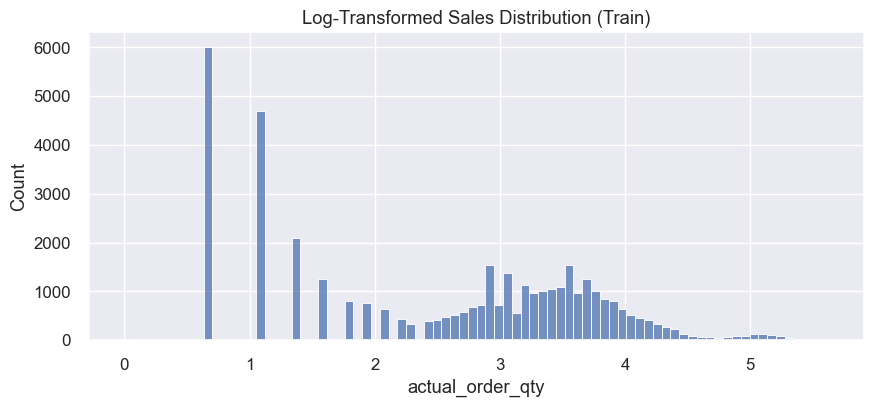

In [7]:
plt.figure(figsize=(10,4))
sns.histplot(df_feat_train[y_col], bins=80)
plt.title("Sales Distribution (Train)")
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(np.log1p(df_feat_train[y_col]), bins=80)
plt.title("Log-Transformed Sales Distribution (Train)")
plt.show()


## SKU별 데이터 개수
모두 동일함

In [8]:
df_feat_train["sku_id"].value_counts().describe()

count    206.0
mean     197.0
std        0.0
min      197.0
25%      197.0
50%      197.0
75%      197.0
max      197.0
Name: count, dtype: float64

In [ ]:
시간 누락 여부 체크

In [13]:
unique_dates = df_feat_train["target_date"].sort_values().unique()

diffs = pd.Series(unique_dates).diff().dropna().dt.days.value_counts()
print(diffs)


7    196
Name: count, dtype: int64


## Weather Feature 분포 분석

In [40]:
weather_cols = ["avg_temp_c", "cdd", "hdd", "precip_mm"]

df_feat_train[weather_cols].describe()


,avg_temp_c,cdd,hdd,precip_mm
count,40582.000000,40582.000000,40582.000000,40582.000000
mean,15.301015,0.120812,4.618782,22.045178
std,7.109279,0.336639,5.065883,9.666821
min,4.400000,0.000000,0.000000,4.700000
25%,8.200000,0.000000,0.000000,12.800000
50%,16.200000,0.000000,1.800000,22.500000
75%,22.400000,0.000000,9.800000,31.400000
max,25.900000,1.900000,13.600000,40.000000


avg_temp_c  
5~26도 사이 균일한 분포  
2년 이상 데이터 기준 매우 정상  
  
cdd / hdd  
대부분 0이고 가끔 튀는 값 : 정상
단, hdd와 cdd가 함께 높게 나오는 패턴은 없음 (음의 상관관계) -> 정상적인 기후 데이터  

precip_mm  
비 오는 주가 고른 분포  
계절별 차이 잘 드러남  

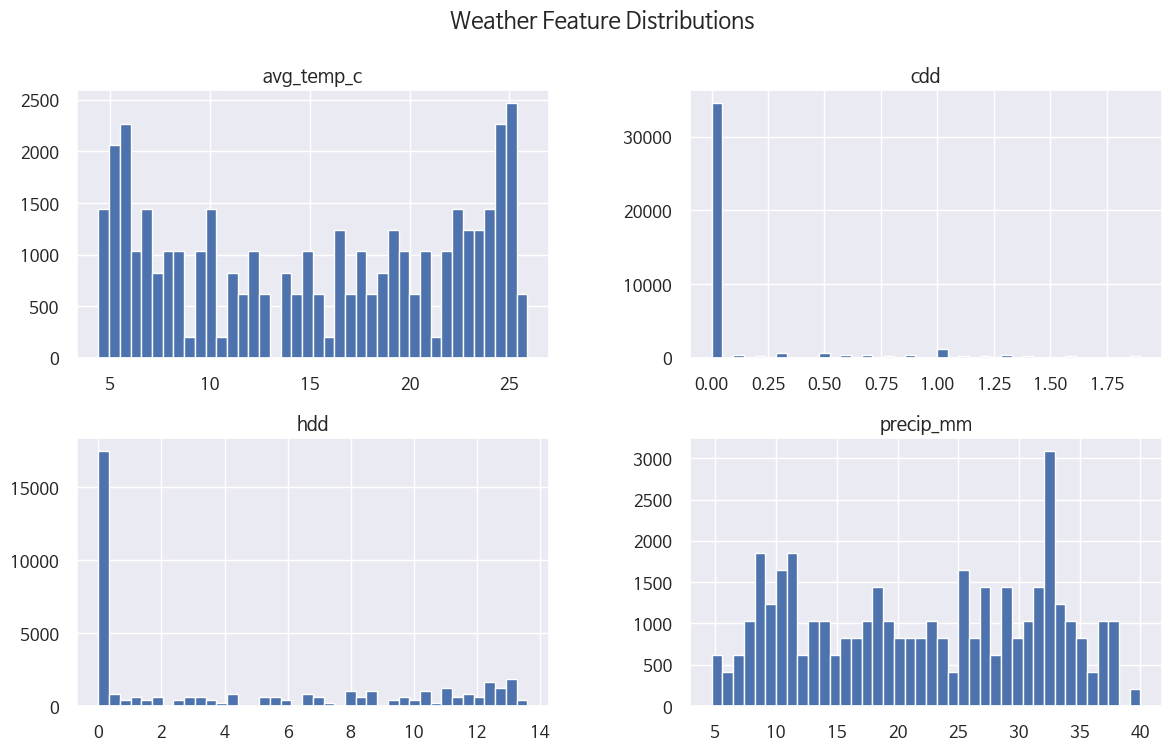

In [41]:
df_feat_train[weather_cols].hist(figsize=(14,8), bins=40)
plt.suptitle("Weather Feature Distributions")
plt.show()


전자제품 판매량은 날씨 영향이 크게 없음  

날씨 변수가 도움 되지 않음  
다만 seasonality는 날씨 외적인 요인(연말 할인, 시즌행사)  
  
즉 Weather는 약한 feature 이지만  
완전히 쓸모없지는 않음 (시즌성과 일정 부분 연관)

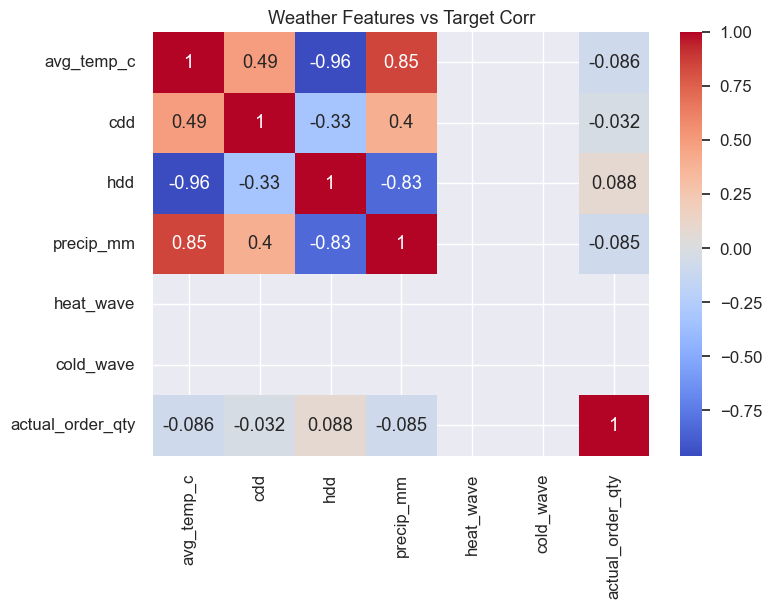

In [16]:
sns.heatmap(df_feat_train[weather_cols + [y_col]].corr(), annot=True, cmap="coolwarm")
plt.title("Weather Features vs Target Corr")
plt.show()


## 범주형 Feature 분석
실제 한국 시장 반영

In [17]:
df_feat_train["cat_low"].value_counts().head(20)
df_feat_train["brand"].value_counts().head(20)

brand
Samsung       13790
LG             8668
Apple          5122
Winia          2758
Dyson          1576
Philips        1576
Cuckoo          788
Nespresso       788
DolceGusto      788
Cuchen          788
Tefal           788
Canon           788
Epson           788
ASUS            788
Netgear         788
Name: count, dtype: int64

## Category 분포  
고르게 잘 퍼짐  
가전류 전체적으로 정상적인 계절성+판매량 패턴을 보여줌

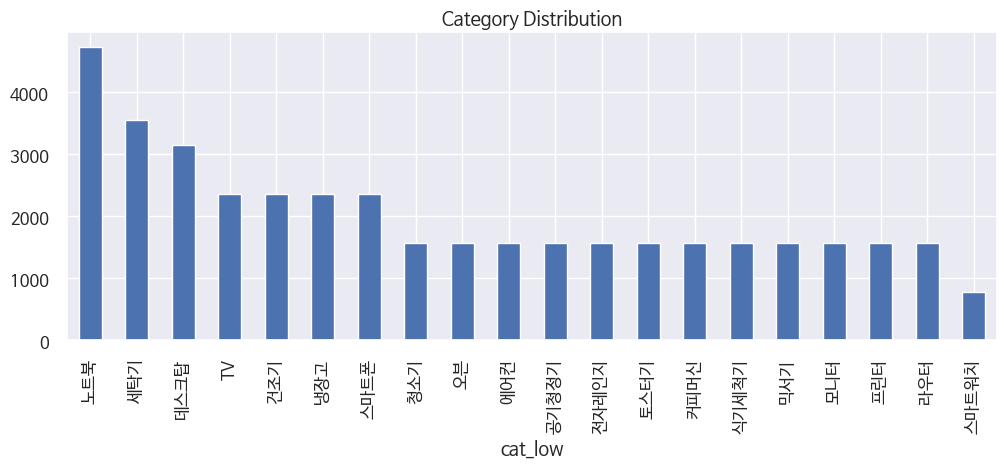

In [20]:
plt.figure(figsize=(12,4))
df_feat_train["cat_low"].value_counts().plot(kind="bar")
plt.title("Category Distribution")
plt.show()


## SKU별 시즌성 분석  
STL Decomposition Light Version   
랜덤 1개   
  
LightGBM이 sin/cos_week으로 어느 정도 학습 가능  
Prophet이나 NeuralProphet류 모델도 테스트해볼 가치 있음  

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_37216\912132265.py:23: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout(pad=3.0)


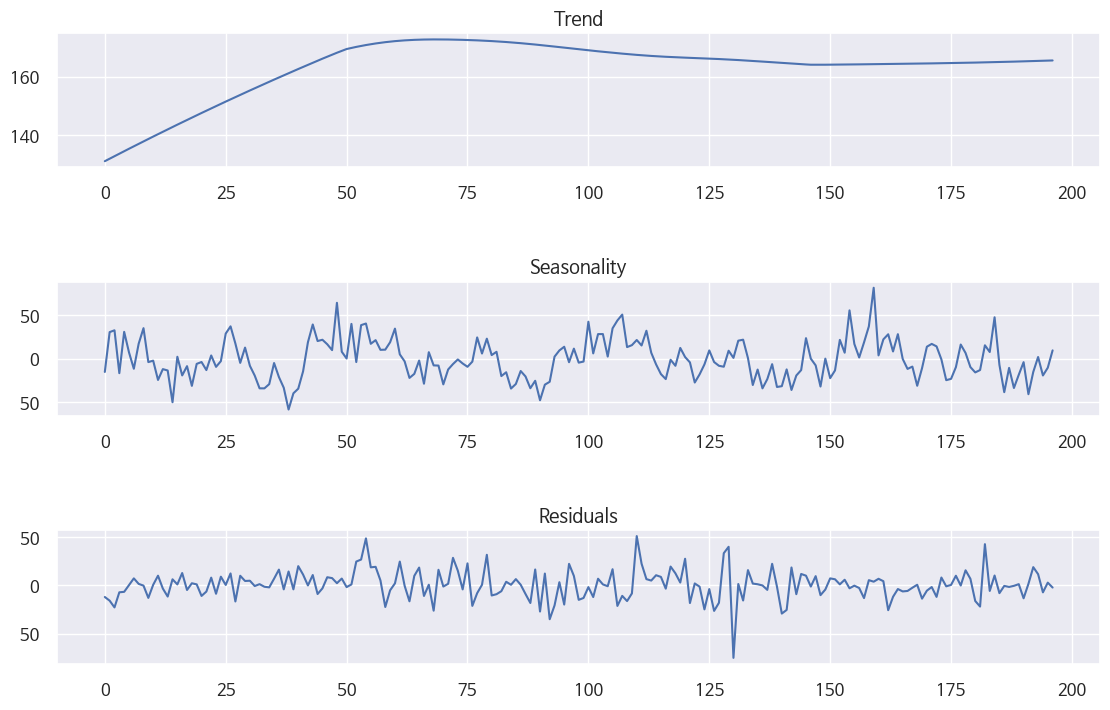

In [39]:
from statsmodels.tsa.seasonal import STL

sample_sku = 202  
tmp = df_feat_train[df_feat_train["sku_id"] == sample_sku].sort_values("target_date")

series = tmp[y_col].values

stl = STL(series, period=52).fit()
res = stl

plt.figure(figsize=(12,8))
plt.subplot(311)
plt.plot(res.trend)
plt.title("Trend")

plt.subplot(312)
plt.plot(res.seasonal)
plt.title("Seasonality")
plt.subplot(313)
plt.plot(res.resid)
plt.title("Residuals")

plt.tight_layout(pad=3.0) 
plt.show()


## Feature Leakage 검사
특히 MA_12, lag_12가 2025년 정보를 사용했는지 체크  
문제 없음 

In [29]:
df_feat.sort_values(["sku_id", "target_date"]).head(20)

,target_date,warehouse_id,store_id,sku_id,actual_order_qty,product_code,cat_low,brand,minor_option,msrp_krw,...,sin_week,cos_week,lag_1,lag_2,lag_4,lag_8,lag_12,ma_4,ma_8,ma_12
0,2021-03-29,1,1,1,38,TV-SAM-55인치-4K-00001,TV,Samsung,55인치-4K,3670000.0,...,1.000000e+00,-1.608123e-16,32.0,40.0,39.0,26.0,0.0,37.50,34.250,28.416667
1,2021-04-05,1,1,1,50,TV-SAM-55인치-4K-00001,TV,Samsung,55인치-4K,3670000.0,...,9.927089e-01,-1.205367e-01,38.0,32.0,39.0,33.0,18.0,37.25,35.750,31.583333
2,2021-04-12,1,1,1,47,TV-SAM-55인치-4K-00001,TV,Samsung,55인치-4K,3670000.0,...,9.709418e-01,-2.393157e-01,50.0,38.0,40.0,27.0,26.0,40.00,37.875,34.250000
3,2021-04-19,1,1,1,41,TV-SAM-55인치-4K-00001,TV,Samsung,55인치-4K,3670000.0,...,9.350162e-01,-3.546049e-01,47.0,50.0,32.0,38.0,23.0,41.75,40.375,36.000000
4,2021-04-26,1,1,1,38,TV-SAM-55인치-4K-00001,TV,Samsung,55인치-4K,3670000.0,...,8.854560e-01,-4.647232e-01,41.0,47.0,38.0,39.0,26.0,44.00,40.750,37.500000
5,2021-05-03,1,1,1,25,TV-SAM-55인치-4K-00001,TV,Samsung,55인치-4K,3670000.0,...,8.229839e-01,-5.680647e-01,38.0,41.0,50.0,39.0,33.0,44.00,40.625,38.500000
6,2021-05-10,1,1,1,30,TV-SAM-55인치-4K-00001,TV,Samsung,55인치-4K,3670000.0,...,7.485107e-01,-6.631227e-01,25.0,38.0,47.0,40.0,27.0,37.75,38.875,37.833333
7,2021-05-17,1,1,1,26,TV-SAM-55인치-4K-00001,TV,Samsung,55인치-4K,3670000.0,...,6.631227e-01,-7.485107e-01,30.0,25.0,41.0,32.0,38.0,33.50,37.625,38.083333
8,2021-05-24,1,1,1,32,TV-SAM-55인치-4K-00001,TV,Samsung,55인치-4K,3670000.0,...,5.680647e-01,-8.229839e-01,26.0,30.0,38.0,38.0,39.0,29.75,36.875,37.083333
9,2021-05-31,1,1,1,39,TV-SAM-55인치-4K-00001,TV,Samsung,55인치-4K,3670000.0,...,4.647232e-01,-8.854560e-01,32.0,26.0,25.0,50.0,39.0,28.25,36.125,36.500000


실제 lag가 타겟보다 항상 이전 날짜인지 검사

In [31]:

test_lag = (
    df_feat_train[["target_date", "lag_1"]]
    .sort_values("target_date")
    .head(10)
)

test_lag


,target_date,lag_1
0,2021-03-29,32.0
41334,2021-03-29,32.0
8964,2021-03-29,2.0
41583,2021-03-29,32.0
8715,2021-03-29,5.0
41832,2021-03-29,32.0
8466,2021-03-29,5.0
42081,2021-03-29,32.0
8217,2021-03-29,5.0
42330,2021-03-29,32.0


전체적으로  
타겟 distribution 문제 없음  
SKU 균일성 최고  
시간적 gap 없음  
전처리 꼼꼼하게 되어 있음  
weather feature도 정상적  
카테고리/브랜드도 좋은 상태  
STL seasonality 잘 잡힘   
Feature leakage 없음  